In [76]:
import os
import sys

sys.path.append('../')

import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize, LogNorm
from matplotlib.gridspec import GridSpec
from scipy.interpolate import interp1d, interp2d, RegularGridInterpolator, CloughTocher2DInterpolator, LinearNDInterpolator
from scipy.integrate import trapezoid

from kwave.ktransducer import kWaveGrid
from utils.data import load_mat
from utils.reconstruction import wavefront_real, wavefront_fourier
from utils.simulations import get_water_SoS
from utils.utils_torch import get_fourier_coord
from utils.visualization import *

data_path = '../data/'

### Load SoS

In [77]:
SoS_phantom = load_mat(os.path.join(data_path, 'SoS.mat'))
SoS_SB = load_mat(os.path.join(data_path, 'SoS_SB.mat'))
SoS_body = load_mat(os.path.join(data_path, 'SoS_body.mat'))
SoS_body_liver = load_mat(os.path.join(data_path, 'SoS_body_liver.mat'))
SoS_uniform = load_mat(os.path.join(data_path, 'SoS_uniform.mat'))

In [78]:
def get_coordinates(i, j, l):
    x, y = (j-12)*l / 4, (12-i)*l / 4
    r, phi = np.sqrt(x**2 + y**2), np.arctan2(x, y)
    return x, y, r, phi

Nx, Ny = 560, 560
dx, dy = 4e-5, 4e-5
N, l = 80, 3.2e-3
i, j = 18, 15
idx, idy = 20*i+40, 20*j+40
x, y, r, phi = get_coordinates(i, j, l)
k2D, theta2D = get_fourier_coord(n_points=N, l=l, device='cpu')
kgrid = kWaveGrid([Nx, Ny], [dx, dy])
x_vec, y_vec = kgrid.x_vec, kgrid.y_vec

In [79]:
R = 9.8e-3 # Radius to center [m].
T = 26.0
v0, v1 = get_water_SoS(T), 1572 # Background SoS & SoS in tissue [m/s].

In [80]:
w_uniform = lambda theta: np.zeros_like(theta)
w_sb = wavefront_real(R, r, phi, v0, v1)
w_body = wavefront_real(R, r, phi, v0, 1555.0)

In [81]:
def wavefront_SoS(SoS, x_vec, y_vec, v0, x, y, r, phi, N=512, N_int=256):
    x_vec, y_vec = np.meshgrid(x_vec, y_vec)
    f_sos = CloughTocher2DInterpolator(list(zip(x_vec.reshape(-1), y_vec.reshape(-1))), SoS.reshape(-1))
    thetas = np.arange(0, 2*np.pi, 2*np.pi/N)
    wfs = []
    for theta in thetas:
        l = (np.sqrt(R**2 - (r*np.sin(theta-phi))**2) + r*np.cos(theta-phi))
        ls = np.linspace(0, l, N_int)
        vs = np.array([f_sos(x-l*np.sin(phi), y-l*np.cos(phi)) for l in ls]).reshape(-1)
        wfs.append(trapezoid(1-v0/vs, ls, l/N_int))

    f_wf = interp1d(thetas, wfs, kind='cubic')    
    return lambda theta: f_wf(np.mod(theta, 2*np.pi))

# w_sb = wavefront_SoS(SoS_SB, x_vec, y_vec, v0, x, y, r, phi)
# w_body = wavefront_SoS(SoS_body, x_vec, y_vec, v0, x, y, r, phi)
w_body_liver = wavefront_SoS(SoS_body_liver, x_vec, y_vec, v0, x, y, r, phi)
w_phantom = wavefront_SoS(SoS_phantom, x_vec, y_vec, v0, x, y, r, phi)
theta1D = torch.arange(0, 2*np.pi, 2*np.pi/N)

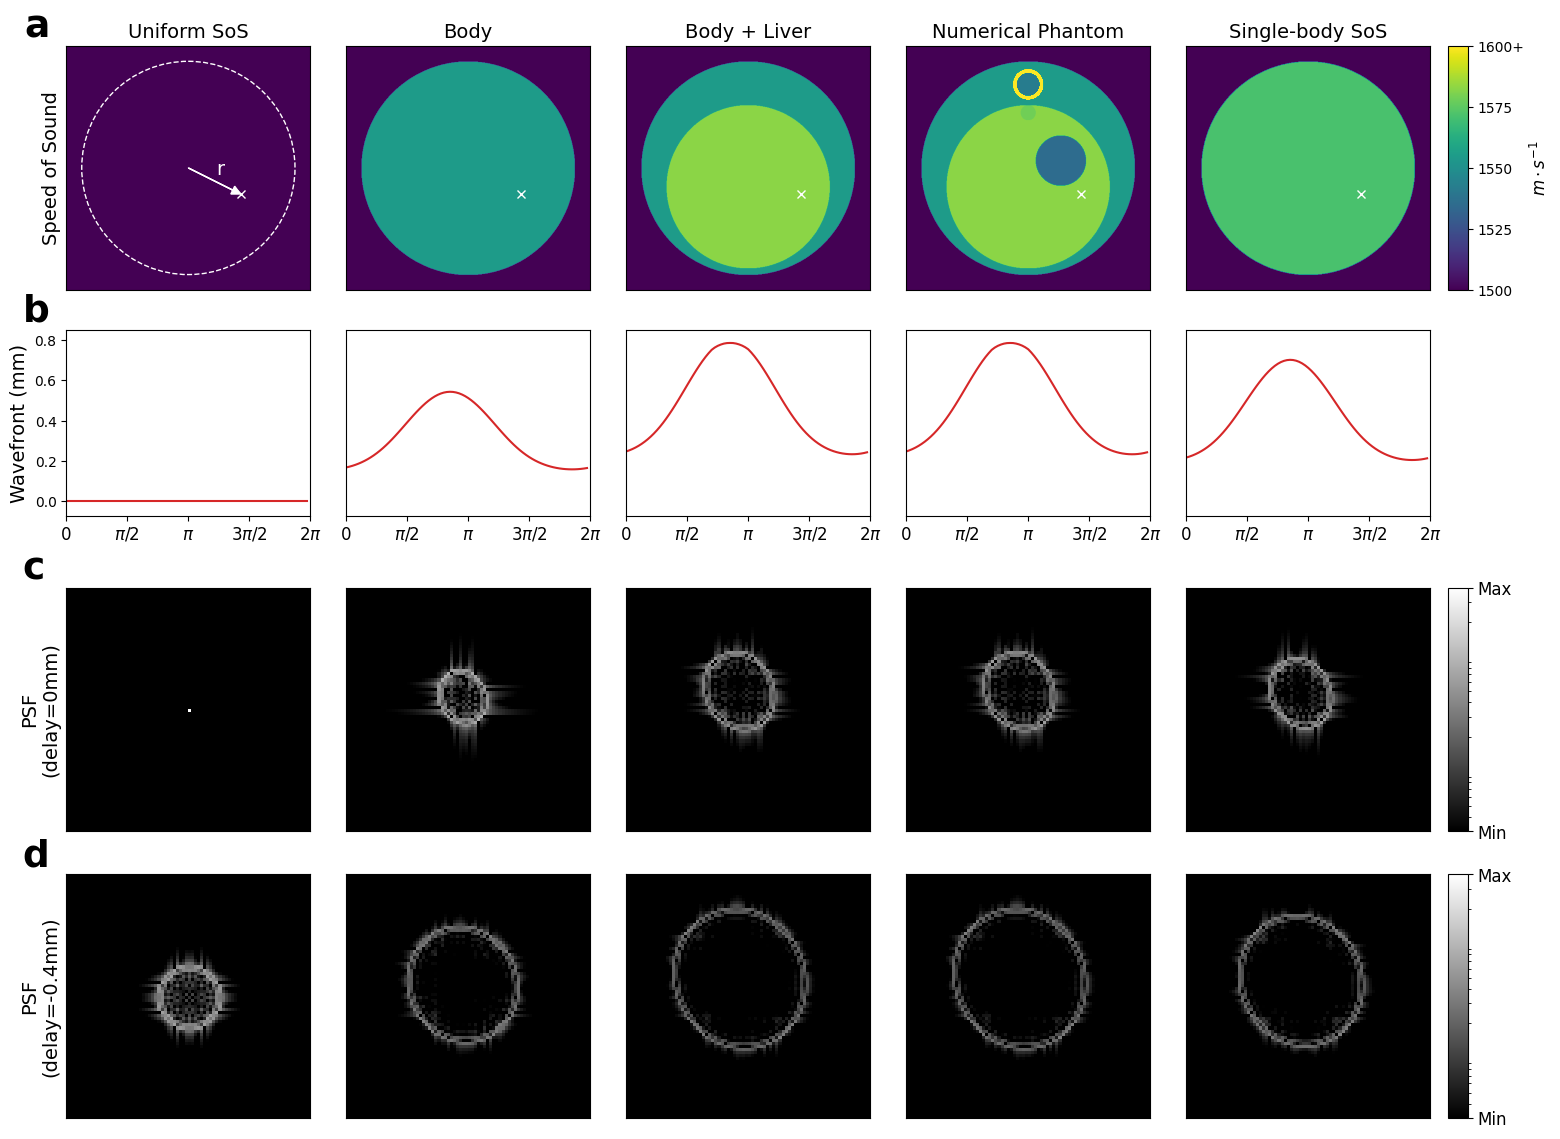

In [82]:
fig = plt.figure(figsize=(18,14))
gs = GridSpec(34, 45)
norm_sos = Normalize(vmax=1600, vmin=1500)
norm_psf = LogNorm(vmin=3e-4, vmax=0.04)
for i, (SoS, wf, title) in enumerate(zip([SoS_uniform, SoS_body, SoS_body_liver, SoS_phantom, SoS_SB],
                                         [w_uniform, w_body, w_body_liver, w_phantom, w_sb],
                                         ['Uniform SoS', 'Body', 'Body + Liver', 'Numerical Phantom', 'Single-body SoS'])):
    ax = plt.subplot(gs[0:8,9*i:9*i+8])
    plt.imshow(SoS, norm=norm_sos)
    plt.plot(idx, idy, marker='x', color='white', markersize=6)
    plt.title(title, fontsize=14)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.arrow(280, 280, (idx-280)*0.85, (idy-280)*0.85, color='white', head_width=20, head_length=20)
        plt.text(s='r', color='white', x=idx-55, y=idy-45, fontsize=14)
        plt.ylabel('Speed of Sound', fontsize=14)
        plt.title('a', loc='left', x=-0.17, y=1.0, fontsize=27, fontweight='bold', color='black')
        circle = plt.Circle((280, 280), R/4e-5, fill=False, linestyle='--', color='white')
        ax.add_artist(circle)
    elif i == 4:
        cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.011, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm_sos)
        cb.ax.set_yticks([1500, 1525, 1550, 1575, 1600])
        cb.ax.set_yticklabels(['1500', '1525', '1550', '1575', '1600+'])
        cb.ax.tick_params(labelsize=10)
        cb.set_label('$m \cdot s^{-1}$', fontsize=12)
    
    ax = plt.subplot(gs[9:15,9*i:9*i+8])
    plt.plot(theta1D, wf(theta1D)*1e3, color='tab:red', label='Real')
    plt.xlim([0, 2*np.pi])
    plt.ylim([-0.07, 0.85])
    plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], ['0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'], fontsize=12)
    if i == 0:
        plt.ylabel('Wavefront (mm)', fontsize=14)
        plt.title('b', loc='left', x=-0.18, y=1.0, fontsize=27, fontweight='bold', color='black')
    else:
        plt.yticks([])

    ax = plt.subplot(gs[17:25,9*i:9*i+8])
    psf = PSF(theta2D, k2D, wf, 0.0)
    psf = np.maximum(psf, 1e-5)
    plt.imshow(psf, cmap='gray', norm=norm_psf)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('PSF\n(delay=0mm)', fontsize=14)
        plt.title('c', loc='left', x=-0.18, y=1.0, fontsize=27, fontweight='bold', color='black')
    elif i == 4:
        cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.011, ax.get_position().height])
        cb = plt.colorbar(cax=cax)
        cb.set_ticks([3e-4, 0.04])
        cb.set_ticklabels(['Min', 'Max'], fontsize=12)
    
    ax = plt.subplot(gs[26:34,9*i:9*i+8])
    psf = PSF(theta2D, k2D, wf, -4e-4)
    psf = np.maximum(psf, 1e-5)
    plt.imshow(psf, cmap='gray', norm=norm_psf)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('PSF\n(delay=-0.4mm)', fontsize=14)
        plt.title('d', loc='left', x=-0.18, y=1.0, fontsize=27, fontweight='bold', color='black')
    elif i == 4:
        cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.011, ax.get_position().height])
        cb = plt.colorbar(cax=cax)
        cb.set_ticks([3e-4, 0.04])
        cb.set_ticklabels(['Min', 'Max'], fontsize=12)
        
plt.savefig('figure_SoS.png', bbox_inches='tight', dpi=256)